In [1]:
%matplotlib inline

In [2]:
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.analysis import maths as iam
from iris.analysis import cartography as iac
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.cm as mpl_cm
import numpy as np
import glob

In [3]:
from skimage.measure import EllipseModel
from scipy import ndimage

In [4]:
import sys
from importlib import reload

sys.path.append(
    "/home/users/schan016/code/NOC_hostace/AnisotropicSpatialSSTVariability/src/"
)
from nonstationary_cov import cube_io_10x10 as cube_io_10

reload(cube_io_10)

<module 'nonstationary_cov.cube_io_10x10' from '/home/users/schan016/code/NOC_hostace/AnisotropicSpatialSSTVariability/src/nonstationary_cov/cube_io_10x10.py'>

In [5]:
plt.rcParams["figure.figsize"] = [15, 10]

In [6]:
month = "04"
v = 1.5
extent = [0.0, 360.0, -90.0, 90.0]

In [7]:
ncpath = "/gws/nopw/j04/hostace/schan016/ERA_SAT_monthly/ANOMALY/"
ncpath += "SpatialScales/matern_physical_distances_v_eq_1p5/"
ncfiles = ncpath + "lsat_" + month + ".nc"

In [8]:
cubes = iris.load(ncfiles)

In [9]:
print(cubes)

0: Lx / (km)                           (latitude: 36; longitude: 72)
1: number_of_iterations / (1)          (latitude: 36; longitude: 72)
2: Ly / (km)                           (latitude: 36; longitude: 72)
3: qc_code / (1)                       (latitude: 36; longitude: 72)
4: standard_deviation / (K)            (latitude: 36; longitude: 72)
5: theta / (radians)                   (latitude: 36; longitude: 72)


In [10]:
Lxs = cubes.extract("Lx")[0]
Lys = cubes.extract("Ly")[0]
thetas = cubes.extract("theta")[0]
thetas_deg = thetas.copy()
thetas_deg.convert_units("degrees")
sdevs = cubes.extract("standard_deviation")[0]
print(repr(Lxs))
print(repr(Lys))
print(repr(thetas_deg))
print(repr(sdevs))

<iris 'Cube' of Lx / (km) (latitude: 36; longitude: 72)>
<iris 'Cube' of Ly / (km) (latitude: 36; longitude: 72)>
<iris 'Cube' of theta / (degrees) (latitude: 36; longitude: 72)>
<iris 'Cube' of standard_deviation / (K) (latitude: 36; longitude: 72)>


In [11]:
qc_table = {
    0.0: "success",
    1.0: "success_reach_lower_bounds",
    2.0: "success_reach_upper_bounds",
    3.0: "success_reach_both_bounds_on_diff_parms",
    9.0: "fail",
}

In [12]:
qc_code = cubes.extract("qc_code")[0]
unique_qc_codes = np.unique(qc_code.data)
n_points = qc_code.data.count()
for unique_qc_code in unique_qc_codes:
    if unique_qc_code != "MaskedConstant":
        print(
            unique_qc_code,
            qc_table[unique_qc_code],
            np.sum(qc_code.data == unique_qc_code),
            np.sum(qc_code.data == unique_qc_code) / n_points,
        )

0.0 success 888 0.9932885906040269
2.0 success_reach_upper_bounds 6 0.006711409395973154


In [13]:
where_123 = np.where(np.ma.isin(qc_code.data, [1.0, 2.0, 3.0]))
if len(list(where_123[0] > 0)):
    print(where_123[0])
    print(where_123[1])
    for y, x in zip(list(where_123[0]), list(where_123[1])):
        print(
            (
                y,
                x,
                Lxs.coord("latitude").points[y],
                Lxs.coord("longitude").points[x],
                Lxs.data[y, x],
                Lys.data[y, x],
                thetas.data[y, x],
            )
        )

[ 0  0  0  0  0 31]
[1 2 7 8 9 0]
(0, 1, -87.5, -172.5, 30000.0, 666.37775, -0.53543663)
(0, 2, -87.5, -167.5, 30000.0, 645.4964, -0.5177774)
(0, 7, -87.5, -142.5, 30000.0, 529.5585, 0.50895673)
(0, 8, -87.5, -137.5, 30000.0, 535.8928, 0.53248245)
(0, 9, -87.5, -132.5, 30000.0, 544.71075, 0.56140196)
(31, 0, 67.5, -177.5, 1543.9994, 30000.0, -0.20997879)


In [14]:
where_9 = np.where(qc_code.data == 9.0)
if len(where_9[0]) > 0:
    print(where_9[0])
    print(where_9[1])
    for y, x in zip(list(where_9[0]), list(where_9[1])):
        print(
            (
                y,
                x,
                Lxs.coord("latitude").points[y],
                Lxs.coord("longitude").points[x],
                Lxs.data[y, x],
                Lys.data[y, x],
                thetas.data[y, x],
            )
        )

(0, 1) (-172.5, -87.5, 30000.0, 666.3777465820312, -30.678259109975833)
(0, 2) (-167.5, -87.5, 30000.0, 645.4963989257812, -29.666458791992238)
(0, 7) (-142.5, -87.5, 30000.0, 529.5584716796875, 29.161072604735484)
(0, 8) (-137.5, -87.5, 30000.0, 535.892822265625, 30.50899677705916)
(0, 9) (-132.5, -87.5, 30000.0, 544.7107543945312, 32.16596310366382)
(31, 0) (-177.5, 67.5, 1543.9993896484375, 30000.0, -12.030898402188267)


/tmp/ipykernel_5108/9849247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x0 = float(Lx_weird.coord('longitude').points)
/tmp/ipykernel_5108/9849247.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y0 = float(Lx_weird.coord('latitude').points)
/tmp/ipykernel_5108/9849247.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x0 = float(Lx_weird.coord('longitude').points)
/tmp/ipykernel_5108/9849247.py:17: DeprecationWarning: Conversion of an array with ndi

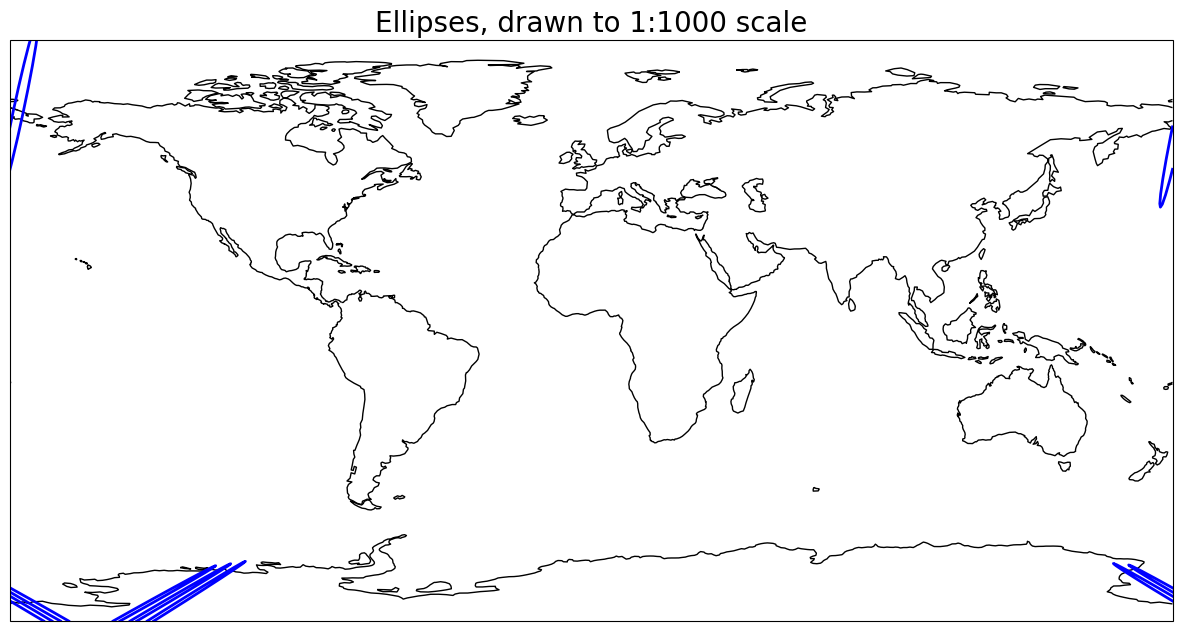

In [15]:
super_y_weird = list(where_9[0]) + list(where_123[0])
super_x_weird = list(where_9[1]) + list(where_123[1])

fig = plt.figure()
if v != 0.5:
    scaling = 1000
else:
    scaling = 3000
extent2 = extent
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
zipper = zip(super_y_weird, super_x_weird)
for n, (y_chk, x_chk) in enumerate(zipper):
    Lx_weird = Lxs[y_chk, x_chk]
    Ly_weird = Lys[y_chk, x_chk]
    theta_weird = thetas[y_chk, x_chk]
    x0 = float(Lx_weird.coord("longitude").points)
    y0 = float(Lx_weird.coord("latitude").points)
    Lx_w = float(Lx_weird.data)
    Ly_w = float(Ly_weird.data)
    angle_w = float(theta_weird.data)
    params = (x0, y0, Lx_w / scaling, Ly_w / scaling, angle_w)
    params0 = (x0, y0, Lx_w, Ly_w, angle_w * 180.0 / np.pi)
    print((y_chk, x_chk), params0)
    xys = EllipseModel().predict_xy(
        np.linspace(0, 2 * np.pi, 25), params=params
    )
    ax.plot(
        xys[:, 0],
        xys[:, 1],
        linewidth=2,
        color="blue",
        transform=ccrs.PlateCarree(),
    )
ax.set_title("Ellipses, drawn to 1:" + str(scaling) + " scale", fontsize=20)
ax.coastlines()

In [16]:
def eccentricity_data_func(axis0_data, axis1_data):
    major_axis = np.maximum(axis1_data, axis0_data)
    minor_axis = np.minimum(axis1_data, axis0_data)
    return np.sqrt(1.0 - minor_axis**2 / major_axis**2)


def eccentricity_units_func(axis0_cube, axis1_cube):
    if axis0_cube.units != getattr(axis0_cube, "units", axis1_cube.units):
        raise ValueError("units do not match")
    return "1"


eccentricity_ifunc = iam.IFunc(eccentricity_data_func, eccentricity_units_func)
eccentricity = eccentricity_ifunc(Lxs, Lys, new_name="eccentricity")

/opt/jaspy/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [17]:
print(Lxs.coord("latitude").points)

[-87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5 -37.5 -32.5
 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5  22.5  27.5
  32.5  37.5  42.5  47.5  52.5  57.5  62.5  67.5  72.5  77.5  82.5  87.5]


In [18]:
print(Lxs.coord("longitude").points)
print(iac.wrap_lons(Lxs.coord("longitude").points, -180, 360))

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5
  172.5  177.5]
[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162

In [19]:
cos_thetas = np.cos(thetas.data)
sin_thetas = np.sin(thetas.data)
cos_latitudes = np.cos(thetas.coord("latitude").points * np.pi / 180.0)
double_coss = cos_thetas * cos_latitudes[:, None]

In [20]:
central_longitude = 0.0

In [21]:
L_levels = np.linspace(0.0, 10000.0, 11)
L_colormap = mpl_cm.get_cmap("BuPu")
theta_levels = np.array([-35, -25, -15, -5, 5, 15, 25, 35])
theta_colormap = mpl_cm.get_cmap("seismic")
sdev_levels = np.linspace(0.0, 2.4, 9)
sdev_colormap = L_colormap
eccentricity_levels = np.linspace(0.0, 1.0, 6)
eccentricity_colormap = L_colormap
crs = ccrs.PlateCarree(central_longitude=central_longitude)

/tmp/ipykernel_5108/162945932.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  L_colormap = mpl_cm.get_cmap("BuPu")
/tmp/ipykernel_5108/162945932.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  theta_colormap = mpl_cm.get_cmap("seismic")


/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/tmp/ipykernel_5108/3012138511.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


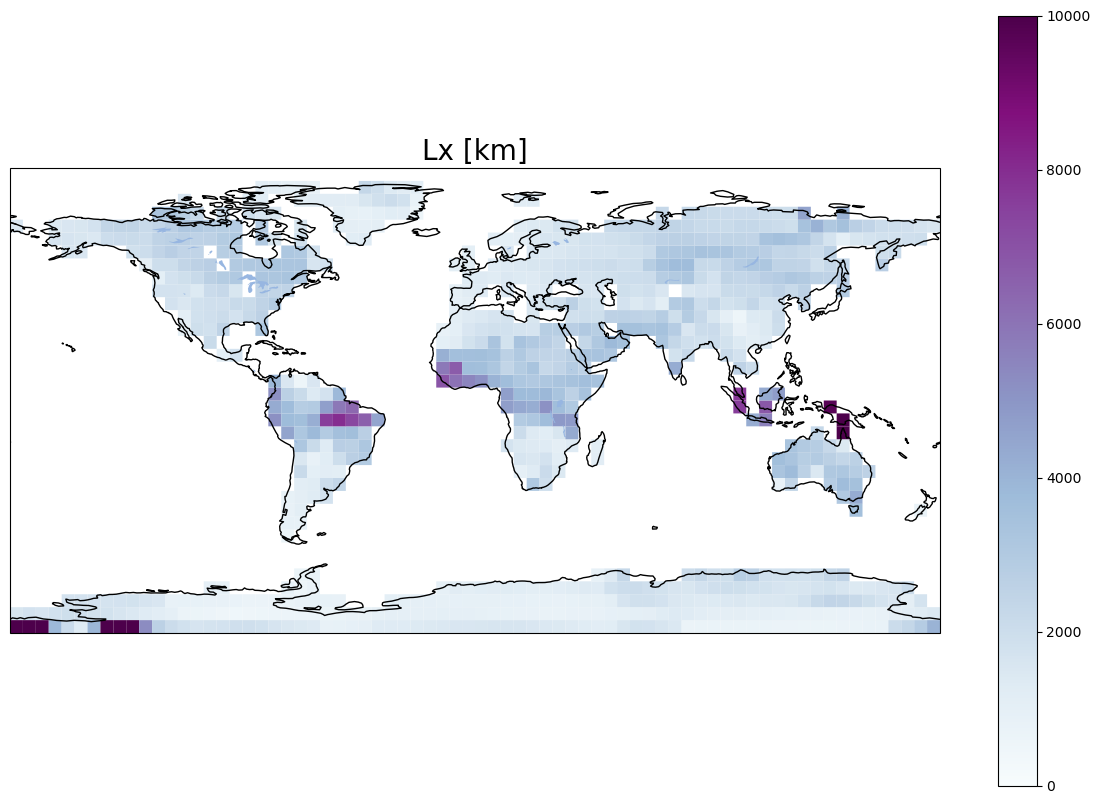

In [22]:
# iplt.contourf(Lxs,
#               levels=L_levels,
#               cmap=L_colormap,
#               extend='max')
iplt.pcolor(Lxs, vmin=L_levels[0], vmax=L_levels[-1], cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title("Lx [km]", fontsize=20)
plt.colorbar()

(array([806.,  70.,   9.,   4.,   0.,   0.,   0.,   0.,   0.,   5.]),
 array([  503.13146973,  3452.81835938,  6402.50537109,  9352.19238281,
        12301.87890625, 15251.56542969, 18201.25195312, 21150.93945312,
        24100.62695312, 27050.3125    , 30000.        ]),
 <BarContainer object of 10 artists>)

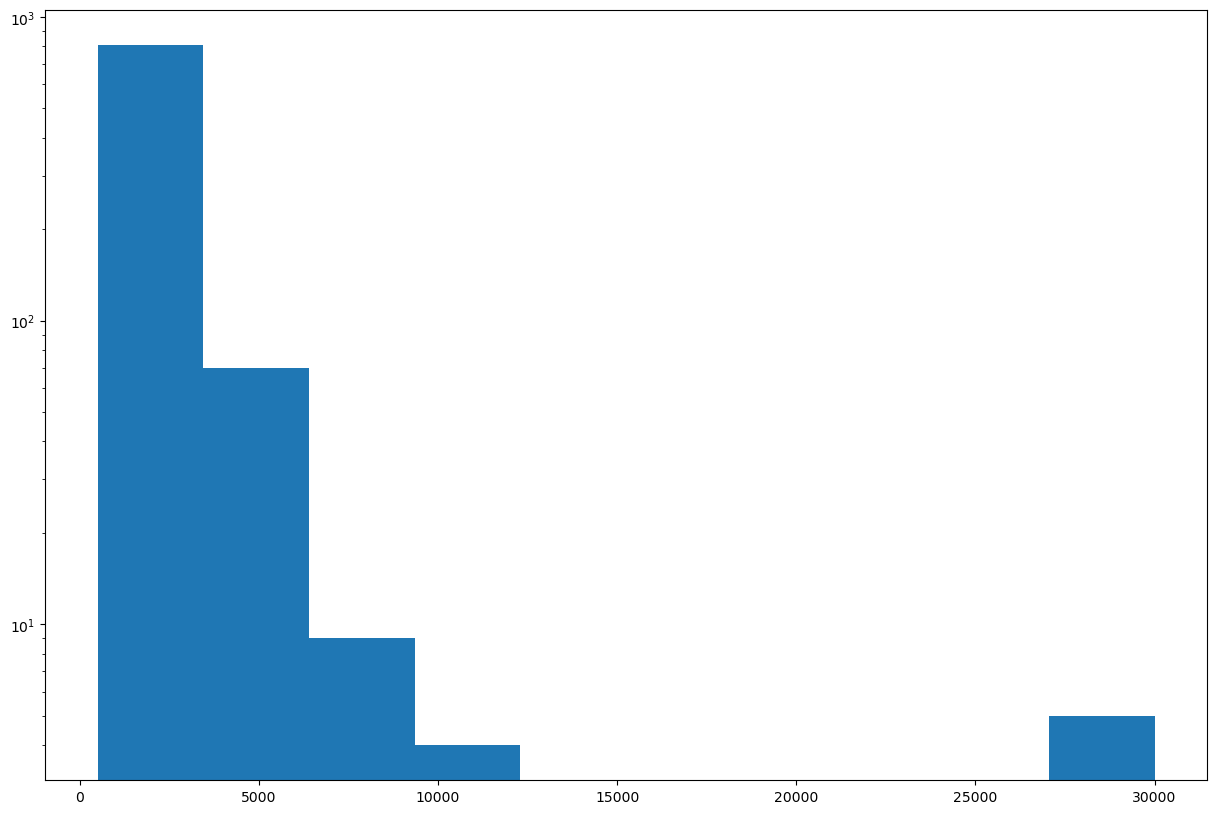

In [23]:
plt.hist(Lxs.data.compressed(), log=True)

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/tmp/ipykernel_5108/4123543250.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


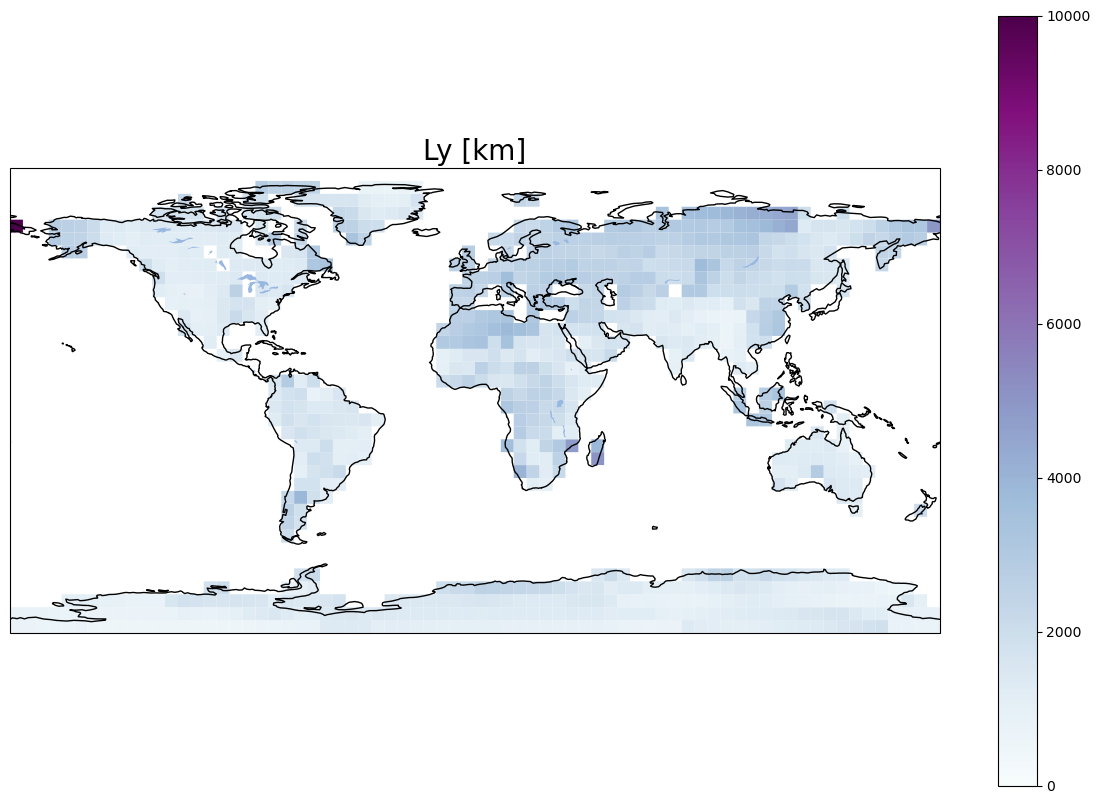

In [24]:
# iplt.contourf(Lys,
#               levels=L_levels,
#               cmap=L_colormap,
#               extend='max')
iplt.pcolor(Lys, vmin=L_levels[0], vmax=L_levels[-1], cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title("Ly [km]", fontsize=20)
plt.colorbar()

(array([867.,  26.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  469.97622681,  3422.97851562,  6375.98095703,  9328.98339844,
        12281.98535156, 15234.98828125, 18187.99023438, 21140.9921875 ,
        24093.99609375, 27046.99804688, 30000.        ]),
 <BarContainer object of 10 artists>)

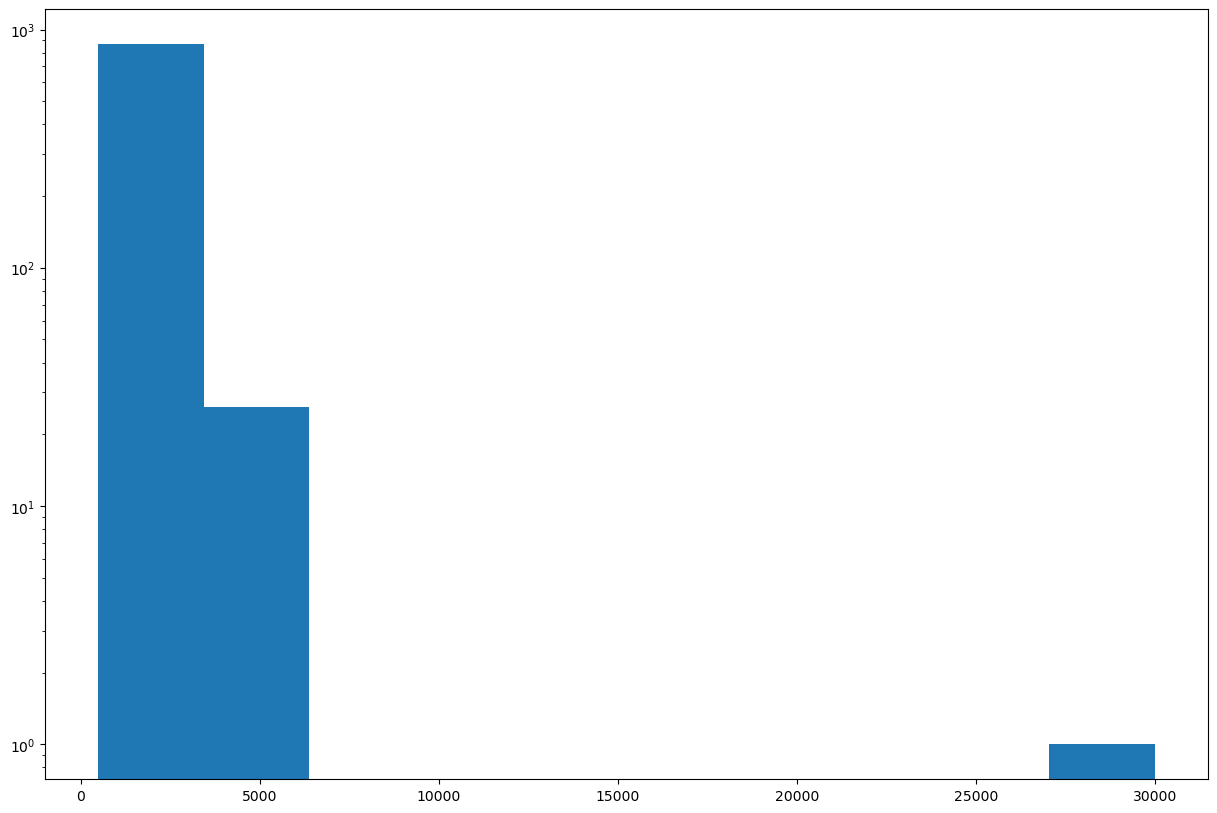

In [25]:
plt.hist(Lys.data.compressed(), log=True)

/opt/jaspy/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/tmp/ipykernel_5108/3011275041.py:13: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


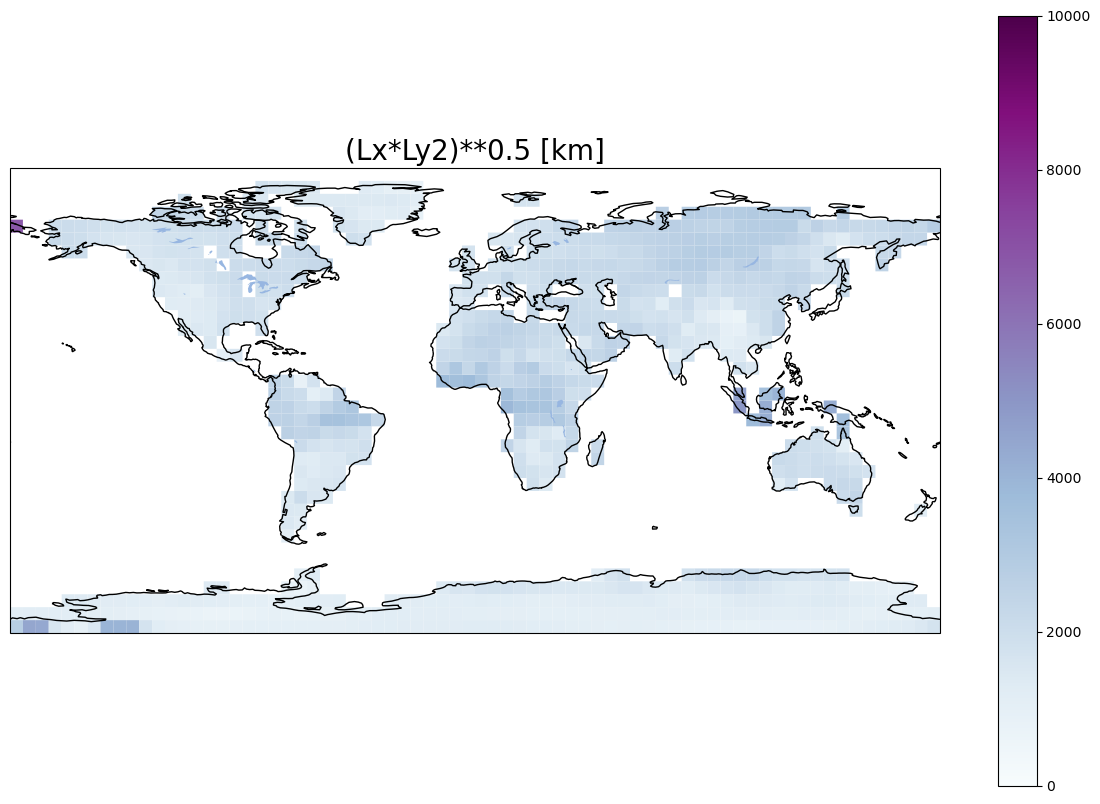

In [26]:
LxLymag = iam.exponentiate(iam.multiply(Lxs, Lys), 0.5)
# iplt.contourf(LxLymag,
#               levels=L_levels,
#               cmap=L_colormap,
#               extend='max')
iplt.pcolor(LxLymag, vmin=L_levels[0], vmax=L_levels[-1], cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title("(Lx*Ly2)**0.5 [km]", fontsize=20)
plt.colorbar()

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/tmp/ipykernel_5108/1647008167.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


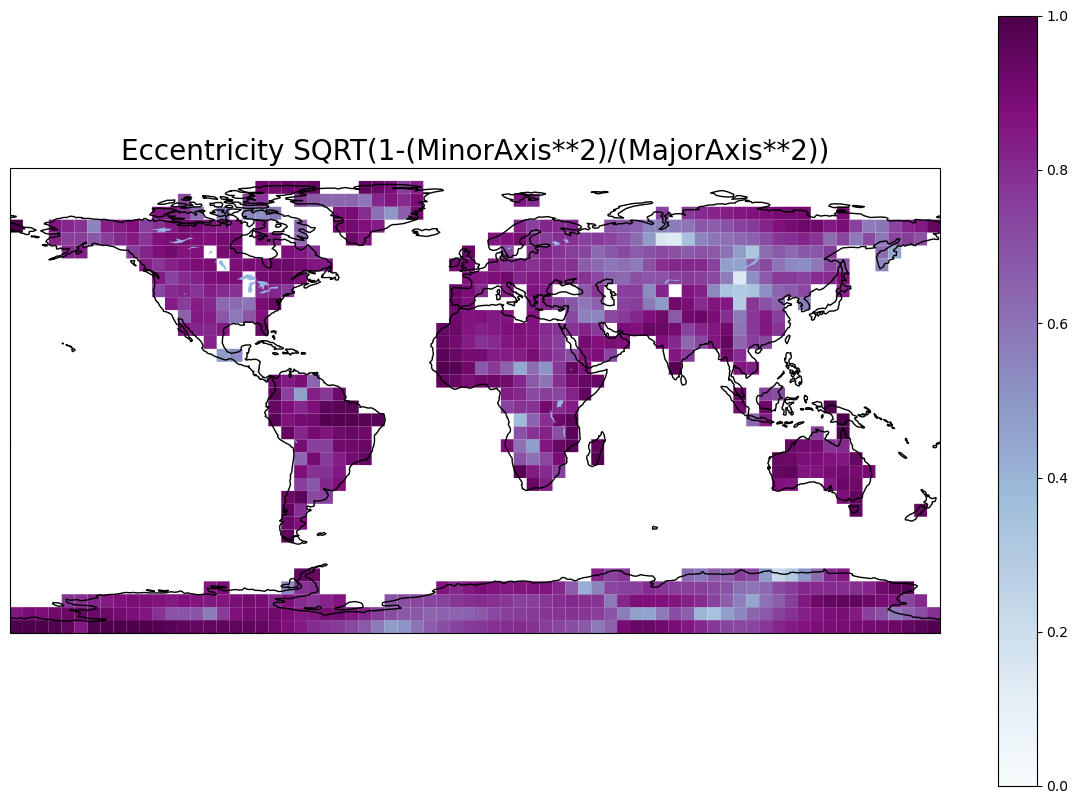

In [27]:
# iplt.contourf(eccentricity,
#               levels=eccentricity_levels,
#               cmap=eccentricity_colormap)
iplt.pcolor(
    eccentricity,
    vmin=eccentricity_levels[0],
    vmax=eccentricity_levels[-1],
    cmap=eccentricity_colormap,
)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title(
    "Eccentricity SQRT(1-(MinorAxis**2)/(MajorAxis**2))", fontsize=20
)
plt.colorbar()

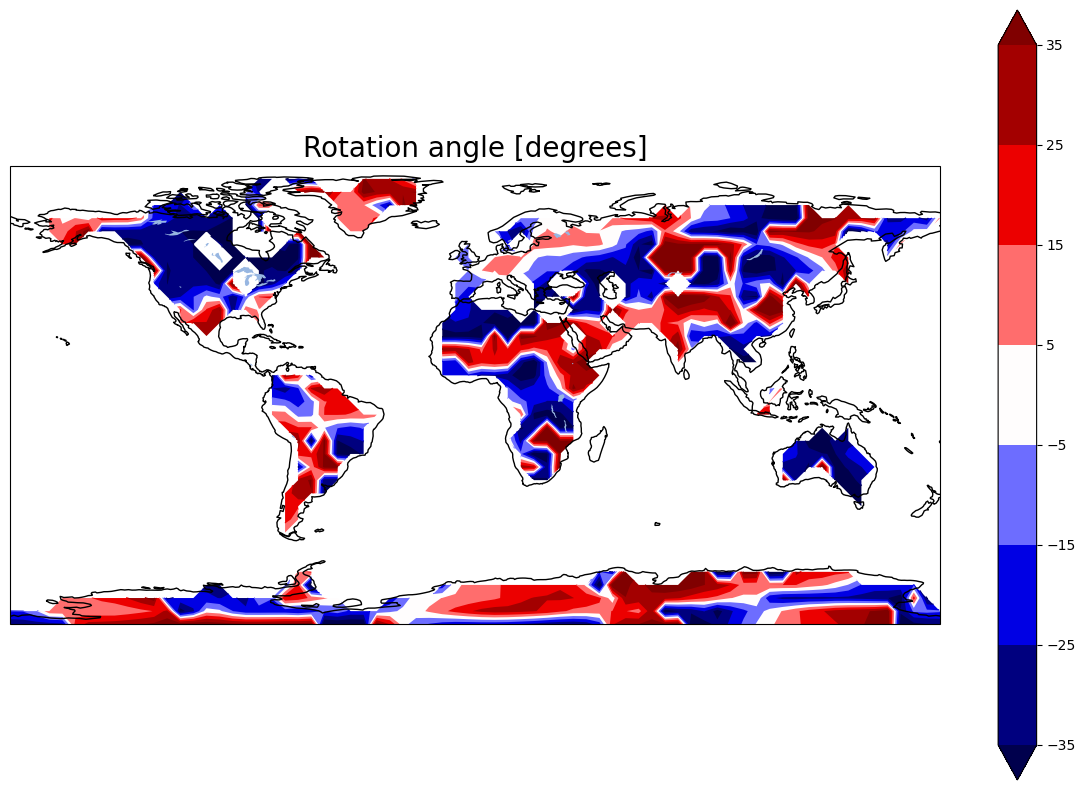

In [28]:
iplt.contourf(
    thetas_deg, levels=theta_levels, cmap=theta_colormap, extend="both"
)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title("Rotation angle [degrees]", fontsize=20)
plt.colorbar()

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/tmp/ipykernel_5108/443289571.py:12: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


/opt/jaspy/lib/python3.11/site-packages/matplotlib/colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


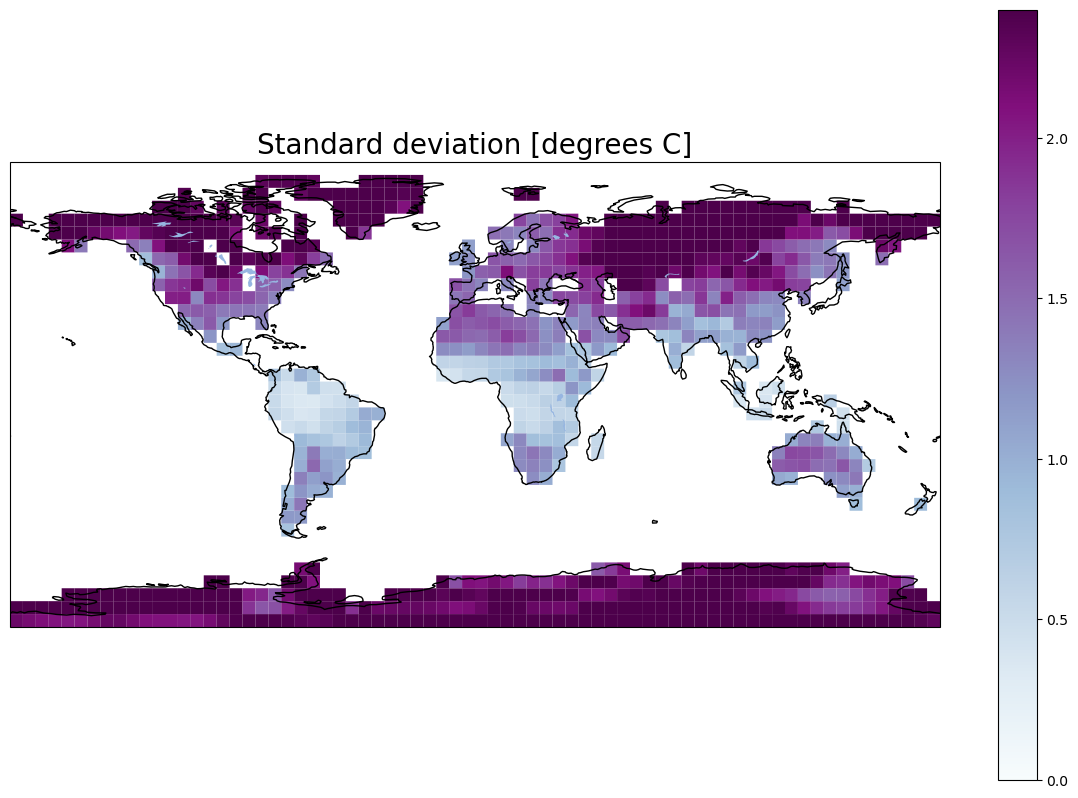

In [29]:
# iplt.contourf(sdevs,
#               levels=sdev_levels,
#               cmap=sdev_colormap,
#               extend='max')
iplt.pcolor(
    sdevs, vmin=sdev_levels[0], vmax=sdev_levels[-1], cmap=sdev_colormap
)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title("Standard deviation [degrees C]", fontsize=20)
plt.colorbar()

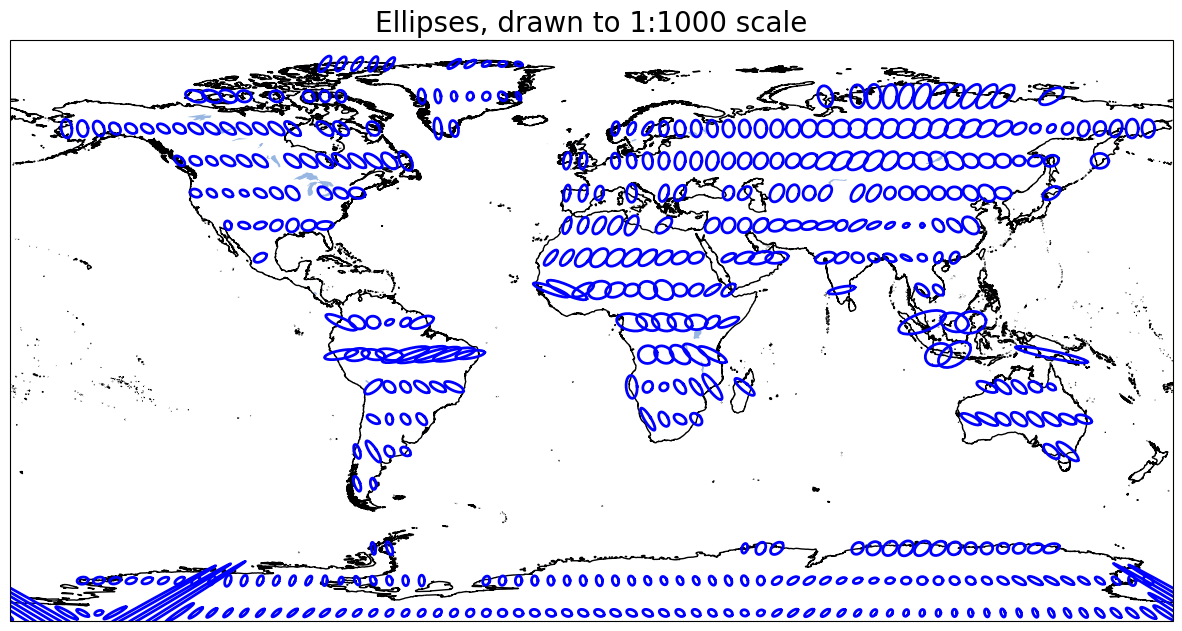

In [30]:
fig = plt.figure()
scaling = 1000
extent2 = extent
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
zipper = zip(
    Lxs.slices(["latitude"]),
    Lys.slices(["latitude"]),
    thetas.slices(["latitude"]),
)
for zonal_count, (Lx_x, Ly_x, theta_x) in enumerate(zipper):
    zipper = zip(Lx_x.slices([]), Ly_x.slices([]), theta_x.slices([]))
    for single_cube_count, (Lx, Ly, theta) in enumerate(zipper):
        if (single_cube_count % 2) != 0:
            continue
        if np.ma.is_masked(Lx.data):
            continue
        x0 = Lx.coord("longitude").points
        y0 = Lx.coord("latitude").points
        Lx = Lx.data
        Ly = Ly.data
        angle = theta.data
        params = (x0, y0, Lx / scaling, Ly / scaling, angle)
        xys = EllipseModel().predict_xy(
            np.linspace(0, 2 * np.pi, 25), params=params
        )
        ax.plot(
            xys[:, 0],
            xys[:, 1],
            linewidth=2,
            color="blue",
            transform=ccrs.PlateCarree(),
        )
ax.set_title("Ellipses, drawn to 1:" + str(scaling) + " scale", fontsize=20)
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAKES)